#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


## Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

define the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon


## Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

define a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

I choose to use 3 dense layers:
<br>Encoder:
<br>Dense(256, activation="relu")
<br>Dense(128, activation="relu")
<br>Dense(64, activation="relu")
<br>
I choose these layers sizes and activation fucntions because I tried different combinations of them and I take the best one so the one with the smallest total loss.

In [ ]:
latent_dim = 2

#[TO COMPLETE]
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x =  tf.keras.layers.Dense(256, activation="relu")(encoder_inputs)
x =  tf.keras.layers.Dense(128, activation="relu")(encoder_inputs)
x =  tf.keras.layers.Dense(64, activation="relu")(x)

z_mean =  tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 128)          100480      input_5[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 64)           8256        dense_15[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_16[0][0]                   
____________________________________________________________________________________________

## Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

The architecture of the decoder should be specular to the encoder architecture:
<br>Dense(64, activation="relu")(latent_inputs)
<br>Dense(128, activation="relu")(x)
<br>Dense(256, activation="relu")(x)
<br>Dense(784, activation="sigmoid")(x)
<br> In the last layer I used a sigmoid activation.
This it's done because the input (all pixels of mnist) are in range 0 and 1 so the output has to be between 0 and 1 and sigmoid activation function forces the output to the range [0, 1].

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

x =  tf.keras.layers.Dense(64, activation="relu")(latent_inputs)
x =  tf.keras.layers.Dense(128, activation="relu")(x)
x =  tf.keras.layers.Dense(256, activation="relu")(x)

decoder_outputs = tf.keras.layers.Dense(784, activation="sigmoid")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               201488    
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_________________________________________________________________


## Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            #[TO COMPLETE]
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction)))
            kl_loss = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))


            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 6s 13ms/step - loss: 35.1361 - reconstruction_loss: 34.2017 - kl_loss: 0.9344
Epoch 2/30
391/391 [==============================] - 5s 13ms/step - loss: 31.3719 - reconstruction_loss: 29.8608 - kl_loss: 1.5111
Epoch 3/30
391/391 [==============================] - 5s 13ms/step - loss: 30.1086 - reconstruction_loss: 27.7881 - kl_loss: 2.3205
Epoch 4/30
391/391 [==============================] - 5s 13ms/step - loss: 29.6284 - reconstruction_loss: 27.0368 - kl_loss: 2.5916
Epoch 5/30
391/391 [==============================] - 5s 13ms/step - loss: 29.2430 - reconstruction_loss: 26.3932 - kl_loss: 2.8498
Epoch 6/30
391/391 [==============================] - 5s 13ms/step - loss: 28.9622 - reconstruction_loss: 25.9393 - kl_loss: 3.0228
Epoch 7/30
391/391 [==============================] - 5s 13ms/step - loss: 28.7873 - reconstruction_loss: 25.6569 - kl_loss: 3.1303
Epoch 8/30
391/391 [==============================] - 5s 13ms/step - loss: 2

## Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

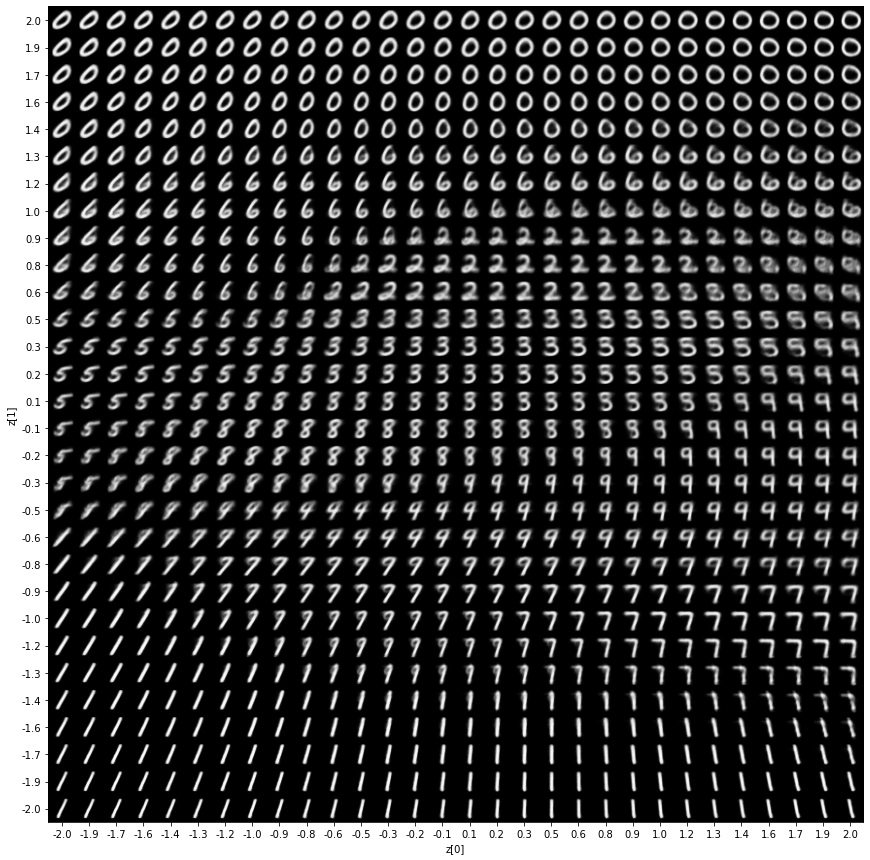

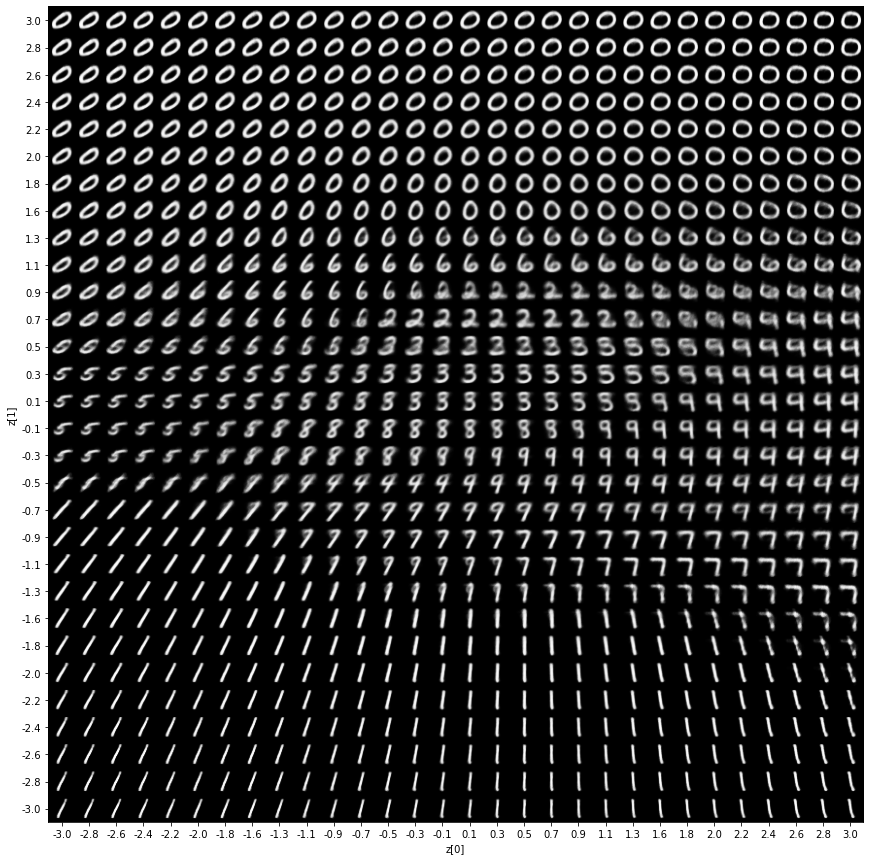

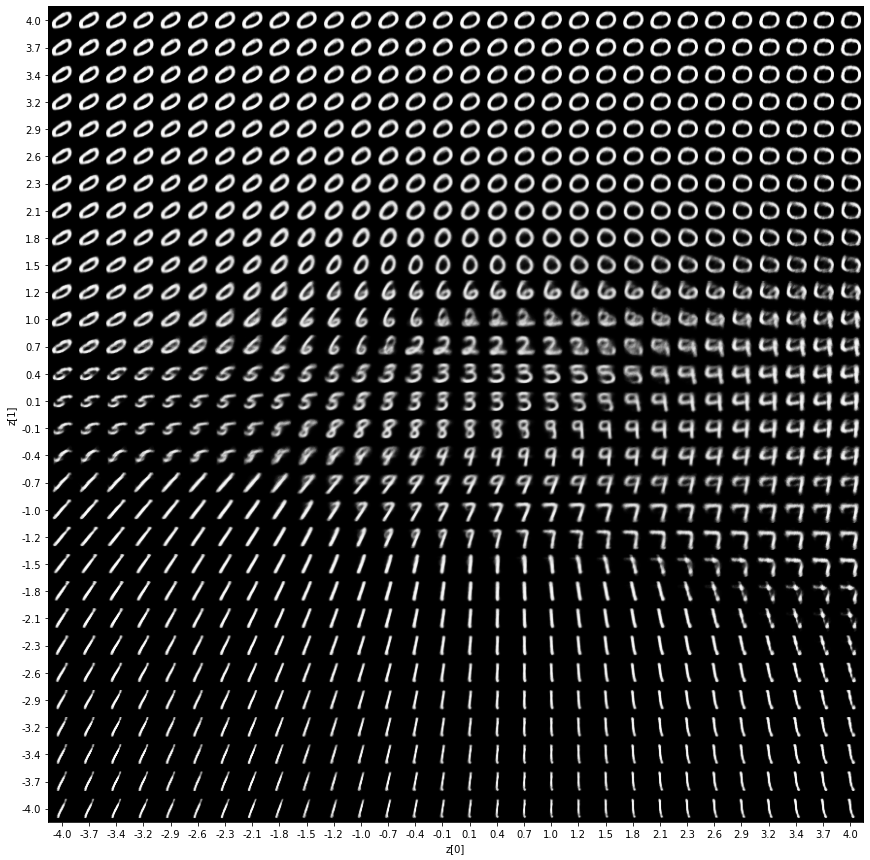

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

# explore with different "scale"
plot_latent(encoder, decoder, 3.0, 30)
plot_latent(encoder, decoder, 4.0, 30)

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

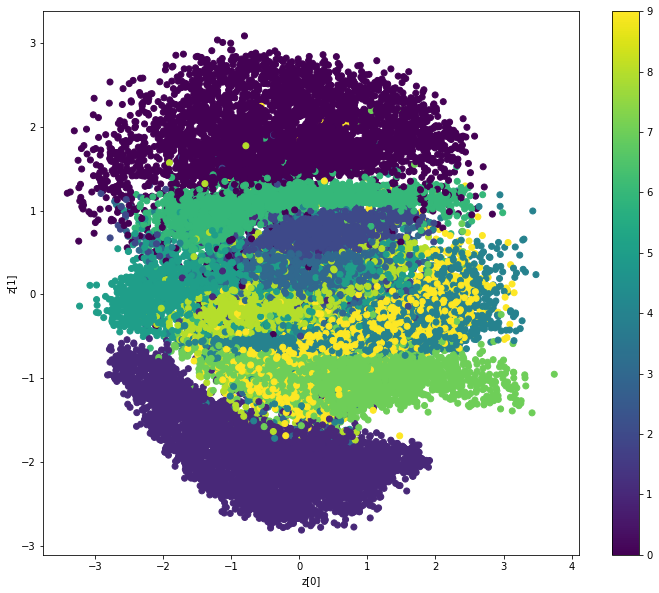

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

In the data generation plot I can see that the most frequent generated digits are 0 and 1 and changing the scale we end up with a larger number of them. 
<br>Looking to the plots above what we end up with is a smoothly varying space where each digit transforms into the others.
<br>In the latent space by the VAE we can see how distribution are really close to each other and some of them (4,9...9,8...3,8) are overlapped.
<br>These results are obtained with the best combination of hyper-parameters.
<br> I tried to print the plots also with different combinations which led me to an higer loss and as I expected the destribution of values was more overlapped in the latent space.
<br>It also brings me to an higher probability of getting noiser digits in the generation.
